In [14]:
import sys
import os
import re
import json
import requests
import PyPDF2
import urllib.request
import tueplots
from tueplots import bundles
from tueplots.constants.color import rgb
from bs4 import BeautifulSoup
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization

sys.path.append('../src/')
import maps
from maps import CONCERNS_MAP, ACTIVITIES_MAP, ACTIVITIES_MAP_SHORT, AGE, SEX


In [3]:
DATA_DIR = '../dat/'

def read_csv_in_folder(folder):
    """
    Reads the csv file in the folder and returns a dataframe.
    """
    csv_file_name = [f for f in os.listdir(os.path.join(DATA_DIR, folder)) if f.endswith('.csv')][0]
    print(csv_file_name)
    df = pd.read_csv(os.path.join(DATA_DIR, folder, csv_file_name))
    # Rename all columns to uppercase
    df.columns = map(str.upper, df.columns)
    df = df[(df[AGE] >= 10) * (df[SEX] != -1)]
    return df

# These are the years for which we have data
years = range(2015, 2022, 2)
# Read the data into a list of dataframes
dataframes = list(map(read_csv_in_folder, map(str, years)))

jul15-cps.csv
nov17-cps.csv
nov19-cps.csv
nov21pub.csv


In [4]:
dataframes[3]["HEPSCON1"].value_counts()

HEPSCON1
 1    40329
 2    38604
-1    12008
Name: count, dtype: int64

HEPSPRE5


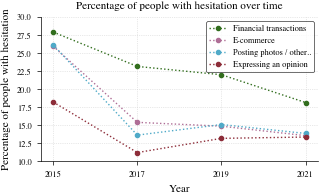

In [26]:
colors = [rgb.tue_darkgreen, rgb.tue_violet, rgb.tue_lightblue, rgb.tue_red]

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):

    fig, ax = plt.subplots()

    for idx, concern in enumerate(ACTIVITIES_MAP):
        concern_percentages = []
        skip = False
        for year, df in zip(years, dataframes):
            # Remove the rows where the df[concern] is -1
            try:
                df = df[df[concern] != -1]
            except:
                print(concern)
                skip = True
                continue

            # Calculate the percentage of people who have the concern in the year
            num_people_with_concern = len(df[df[concern] == 1])
            num_people = len(df)
            concern_percentages.append(num_people_with_concern / num_people * 100)
        
        if not skip:
            # Plot the concern percentages
            ax.plot(
                years,
                concern_percentages, 
                label=ACTIVITIES_MAP_SHORT[concern][:22]+".." if len(ACTIVITIES_MAP_SHORT[concern]) > 22 else ACTIVITIES_MAP_SHORT[concern],
                color = colors[idx],
                ls=':',
                marker="."
                )

    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage of people with hesitation")
    ax.set_title("Percentage of people with hesitation over time")
    ax.set_ylim([10,30])

    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    ax.grid(True, color = "lightgrey", ls = ":")

    # Set ticks
    ax.set_xticks(years)

    plt.legend()
    plt.savefig("../res/figures/activity_over_time.pdf")
    plt.show()
    plt.close(fig)